In [74]:
import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)
from dask.distributed import Client, progress
client = Client(n_workers = 9, threads_per_worker=4, memory_limit='80GB')
import noaa_coops as nc
import xarray as xr
import pandas as pd
from netCDF4 import Dataset, num2date
import matplotlib.pyplot as plt
import numpy.polynomial.polynomial as poly
import datetime as dt
from mpl_toolkits.basemap import Basemap

In [75]:
#open NTR montlhy avg
filename = 'NTR' + '.pkl'
NTR = pd.read_pickle(filename)
NTR

,0
date_time,
2000-05-31,0.584285
2000-06-30,0.029070
2000-07-31,0.315883
2000-08-31,0.269126
2000-09-30,0.342489
...,...
2021-01-31,0.571204
2021-02-28,0.708141
2021-03-31,0.611819


In [76]:
NTR = NTR.rename(columns = {0:'NTR'})
NTR
NTR = NTR.rename_axis('time')
NTR

,NTR
time,
2000-05-31,0.584285
2000-06-30,0.029070
2000-07-31,0.315883
2000-08-31,0.269126
2000-09-30,0.342489
...,...
2021-01-31,0.571204
2021-02-28,0.708141
2021-03-31,0.611819


In [77]:
#open wind speed file as xarray
ds = xr.open_dataset('wspd.mon.mean.nc')
ds

<xarray.Dataset>
Dimensions:  (lat: 73, level: 17, lon: 144, time: 881)
Coordinates:
  * level    (level) float32 1e+03 925.0 850.0 700.0 ... 50.0 30.0 20.0 10.0
  * lat      (lat) float32 90.0 87.5 85.0 82.5 80.0 ... -82.5 -85.0 -87.5 -90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time     (time) datetime64[ns] 1948-01-01 1948-02-01 ... 2021-05-01
Data variables:
    wspd     (time, level, lat, lon) float32 ...
Attributes:
    title:          monthly mean wind speed from 4-times daily u and v from t...
    description:    Data from NCEP initialized reanalysis (4x/day).  These ar...
    platform:       Model
    Conventions:    COARDS
    NCO:            20121012
    history:        Mon Jul  5 23:05:54 1999: ncrcat wspd.mon.mean.nc /Datase...
    dataset_title:  NCEP-NCAR Reanalysis 1
    References:     http://www.psl.noaa.gov/data/gridded/data.ncep.reanalysis...

In [513]:
#load variables
wspd = ds.variables['wspd'][:]
time = ds.variables['time']
lon = ds.variables['lon'][:]
lat = ds.variables['lat'][:]
level = ds.variables['level'][:]
#create 2D lat and lon
import numpy as np
lon, lat = np.meshgrid(lon, lat)

In [173]:
df = ds['wspd'].to_dataframe()
#df

In [80]:
#make same time range as NTR 
wspdDF=df.loc['2000-05-01':'2021-05-01']
wspdDF

wspd
time       level  lat   lon             
2000-05-01 1000.0  90.0 0.0     3.880005
                        2.5     3.869995
                        5.0     3.880005
                        7.5     3.880005
                        10.0    3.880005
...                                  ...
2021-05-01 10.0   -90.0 347.5  14.747640
                        350.0  14.743247
                        352.5  14.747523
                        355.0  14.744506
                        357.5  14.746599

[45212112 rows x 1 columns]

In [81]:
#convert wspd back to xarray
wspdxr = wspdDF.to_xarray()
##wspdxr

<xarray.Dataset>
Dimensions:  (lat: 73, level: 17, lon: 144, time: 253)
Coordinates:
  * time     (time) datetime64[ns] 2000-05-01 2000-06-01 ... 2021-05-01
  * level    (level) float64 1e+03 925.0 850.0 700.0 ... 50.0 30.0 20.0 10.0
  * lat      (lat) float64 90.0 87.5 85.0 82.5 80.0 ... -82.5 -85.0 -87.5 -90.0
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Data variables:
    wspd     (time, level, lat, lon) float32 3.88 3.87 3.88 ... 14.74 14.75

In [82]:
#convert NTR to xarray
ntrxr = NTR.to_xarray()
ntrxr


<xarray.Dataset>
Dimensions:  (time: 253)
Coordinates:
  * time     (time) datetime64[ns] 2000-05-31 2000-06-30 ... 2021-05-31
Data variables:
    NTR      (time) float64 0.5843 0.02907 0.3159 ... 0.6118 0.4672 0.3988

In [506]:
#merge two xarray
new = xr.merge([wspdxr, ntrxr])
new

<xarray.Dataset>
Dimensions:  (lat: 73, level: 17, lon: 144, time: 506)
Coordinates:
  * time     (time) datetime64[ns] 2000-05-01 2000-05-31 ... 2021-05-31
  * level    (level) float64 1e+03 925.0 850.0 700.0 ... 50.0 30.0 20.0 10.0
  * lat      (lat) float64 90.0 87.5 85.0 82.5 80.0 ... -82.5 -85.0 -87.5 -90.0
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Data variables:
    wspd     (time, level, lat, lon) float32 3.88 3.87 3.88 3.88 ... nan nan nan
    NTR      (time) float64 nan 0.5843 nan 0.02907 nan ... nan 0.4672 nan 0.3988

In [507]:
#select wind speed at certain level
#windspd = new['wspd'].sel(level=500).dropna('time')
#import random
#level_list = [1000, 925, 850, 700, 600, 500, 400, 300, 250, 200, 150, 100, 70, 50, 30, 20, 10]
#windlevel = new['wspd'].sel(level=random.choice(level_list)).dropna('time')
#windlevel

In [508]:
#drop na values of ntr
ntr = new['NTR'].dropna('time')
ntr

<xarray.DataArray 'NTR' (time: 253)>
array([ 0.58428472,  0.02906989,  0.31588281,  0.2691263 ,  0.34248925,
        0.29588802,  0.13272312, -0.07896094, -0.20745573, -0.17514435,
        0.10520182, -0.31287634,  0.18618229, -0.04886156,  0.1552513 ,
       -0.13701953,  0.23834005,  0.13830469,  0.06931317,  0.09172396,
       -0.35398828,  0.01972126, -0.05772135,  0.0808172 ,  0.11538932,
        0.3754422 , -0.03678255,  0.33377995,  0.30602151,  0.36873177,
       -0.20725403, -0.16670182, -0.25839583, -0.21801868,  0.39201432,
        0.31819355,  0.14007943,  0.00414516, -0.45388932, -0.42397786,
        0.33182124,  0.16071615,  0.0605914 , -0.09836589, -0.05003516,
        0.16255   , -0.11806641, -0.37449328, -0.27067057, -0.01288172,
        0.01935026, -0.11141276,  0.12491935,  0.27219141, -0.0349879 ,
       -0.24040104,  0.32778906,  0.44890661, -0.06774479,  0.064125  ,
        0.30716536,  0.32954301,  0.02274349,  0.27635547,  0.49293952,
        0.36207682, -0.23078611, -0.22169271,  0.00440365, -0.0483046 ,
        0.03522005, -0.13495296,  0.26841146,  0.08213306, -0.18307161,
        0.02171484,  0.24181989,  0.00484245,  0.04812231,  0.013     ,
        0.0229388 , -0.04566092, -0.0870026 , -0.0030336 ,  0.38819922,
        0.44638038,  0.26363021,  0.03836589,  0.35121774,  0.27795964,
       -0.04964651, -0.06889974, -0.15866406, -0.21999444, -0.28938932,
        0.20600672,  0.23672266, -0.15353226,  0.05951823,  0.36856771,
...
        0.21383737,  0.34033203,  0.11044624,  0.1366888 ,  0.3141875 ,
        0.32902016,  0.40316536,  0.2134543 ,  0.13434896,  0.21990365,
        0.50333333,  0.4594974 ,  0.46558333,  0.31824479,  0.47175538,
        0.41800391,  0.57853906,  0.69006317,  0.2343151 ,  0.23613306,
        0.52232552,  0.53447917,  0.53881994,  0.30328906,  0.24322581,
        0.40276562,  0.14186022,  0.35341406,  0.35964974,  0.44063978,
        0.98786458,  0.60142339,  0.67045833,  0.68844922,  0.474825  ,
        0.39114453,  0.48504839,  0.46029036,  0.75847312,  0.13736198,
        0.23268229,  0.25336156,  0.79191016,  0.59258065,  0.45194141,
        0.19232943,  0.19959195,  0.07168229,  0.39921774,  0.19552344,
        0.44896371,  0.2413763 ,  0.48184896,  0.8562621 ,  0.4543776 ,
        0.34486156,  0.21401432,  0.12338542,  0.28290948,  0.62746615,
        0.23565188,  0.18095443,  0.17733333,  0.48255339,  0.1576901 ,
        0.41425806,  0.35128255,  0.5939207 ,  0.53670052,  0.44257292,
        0.72204598,  0.747375  ,  0.46861962,  0.54459635,  0.62071528,
        0.69082682,  0.5841263 ,  0.74334409,  0.79299609,  0.8155457 ,
        0.50796745,  0.4910651 ,  0.53035972,  0.46512891,  0.60320565,
        0.51391406,  0.65301613,  0.64175781,  0.54260937,  0.81694355,
        0.79218099,  0.73488844,  0.3770625 ,  0.57120443,  0.7081408 ,
        0.61181901,  0.46724194,  0.39878241])
Coordinates:
  * time     (time) datetime64[ns] 2000-05-31 2000-06-30 ... 2021-05-31

In [514]:
#select for wspd variable from original dataset
wind_ds = ds['wspd']
#wind_ds

In [515]:
#convert to numpy array
#rawdata = wind_ds.values
#rawdata.shape
#time = 881, level = 17, lat=73, lon=144

In [519]:
#select same time range as NTR and select for a single level
da_ = wind_ds.isel(time=slice(628, 881), level=1)
da_

<xarray.DataArray 'wspd' (time: 253, lat: 73, lon: 144)>
array([[[ 4.190002,  4.179993, ...,  4.190002,  4.190002],
        [ 4.119995,  4.080002, ...,  4.220001,  4.169998],
        ...,
        [10.569992, 10.360001, ..., 10.970001, 10.779999],
        [ 9.199997,  9.199997, ...,  9.199997,  9.199997]],

       [[ 9.319992,  9.319992, ...,  9.330002,  9.319992],
        [ 8.559998,  8.589996, ...,  8.490005,  8.529999],
        ...,
        [10.169998, 10.020004, ..., 10.470001, 10.339996],
        [ 9.580002,  9.580002, ...,  9.580002,  9.580002]],

       ...,

       [[10.952627, 10.947805, ..., 10.945541, 10.947076],
        [10.548664, 10.704782, ..., 10.222379, 10.390314],
        ...,
        [ 9.802945,  9.758825, ...,  9.892106,  9.851457],
        [ 9.483333,  9.481946, ...,  9.484097,  9.48065 ]],

       [[10.2209  , 10.226565, ..., 10.223204, 10.220484],
        [ 9.382018,  9.406269, ...,  9.332288,  9.357863],
        ...,
        [ 8.371873,  8.299364, ...,  8.515863,  8.443777],
        [ 7.957238,  7.950759, ...,  7.954454,  7.954376]]], dtype=float32)
Coordinates:
    level    float32 925.0
  * lat      (lat) float32 90.0 87.5 85.0 82.5 80.0 ... -82.5 -85.0 -87.5 -90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time     (time) datetime64[ns] 2000-05-01 2000-06-01 ... 2021-05-01
Attributes:
    long_name:     Monthly mean wind speed from daily wind speed (from daily ...
    units:         m/s
    precision:     2
    var_desc:      Wind Speed
    level_desc:    Multiple levels
    statistic:     Mean
    parent_stat:   Other
    valid_range:   [  0. 200.]
    dataset:       NCEP Reanalysis Derived Products
    actual_range:  [  0.5399933 126.53999  ]

In [520]:
#make 2D to contain only lat and lon dimensions
Data = da_[0,:]
Data.shape
Data

<xarray.DataArray 'wspd' (lat: 73, lon: 144)>
array([[ 4.190002,  4.179993,  4.190002, ...,  4.190002,  4.190002,  4.190002],
       [ 4.119995,  4.080002,  4.029999, ...,  4.270004,  4.220001,  4.169998],
       [ 5.319992,  5.259995,  5.209991, ...,  5.410004,  5.389999,  5.349991],
       ...,
       [12.119995, 11.809998, 11.479996, ..., 12.910004, 12.669998, 12.410004],
       [10.569992, 10.360001, 10.130005, ..., 11.149994, 10.970001, 10.779999],
       [ 9.199997,  9.199997,  9.199997, ...,  9.190002,  9.199997,  9.199997]],
      dtype=float32)
Coordinates:
    level    float32 925.0
  * lat      (lat) float32 90.0 87.5 85.0 82.5 80.0 ... -82.5 -85.0 -87.5 -90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
    time     datetime64[ns] 2000-05-01
Attributes:
    long_name:     Monthly mean wind speed from daily wind speed (from daily ...
    units:         m/s
    precision:     2
    var_desc:      Wind Speed
    level_desc:    Multiple levels
    statistic:     Mean
    parent_stat:   Other
    valid_range:   [  0. 200.]
    dataset:       NCEP Reanalysis Derived Products
    actual_range:  [  0.5399933 126.53999  ]

In [521]:
##make array with only time to calculate correlations with NTR
#windtime = da_[:,0, 0]
#windtime
#xr.corr(ntr, windtime)

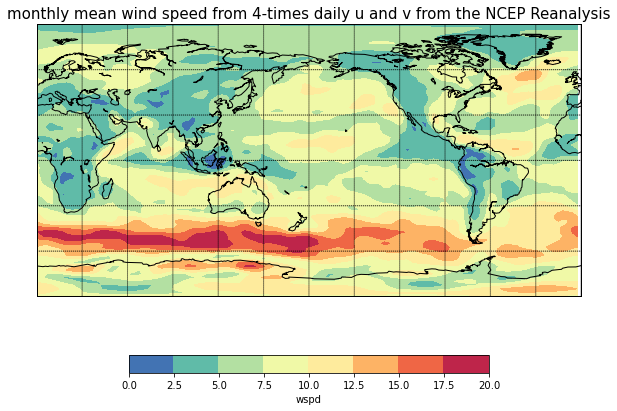

In [522]:
#create basemap
fig = plt.figure(figsize=(10, 6))
fig.subplots_adjust(left=0., right=1., bottom=0., top=0.9)
m = Basemap(projection='cyl', llcrnrlat=-90, urcrnrlat=90,\
            llcrnrlon=0, urcrnrlon=360, resolution='c', lon_0=0)
m.drawcoastlines()
m.drawmapboundary()
# draw lat/lon grid lines every 30 degrees.
m.drawmeridians(np.arange(0,360,30))
m.drawparallels(np.arange(-90,90,30))
# compute native map projection coordinates of lat/lon grid.
lats = dr_surf['lat'].values
lons = dr_surf['lon'].values

# find x,y of map projection grid.
lons, lats = np.meshgrid(lons, lats)
x, y = m(lons, lats)

cs = m.contourf(x, y, Data, cmap=plt.cm.Spectral_r)
cbar = plt.colorbar(cs, orientation='horizontal', shrink=0.5)
plt.title('monthly mean wind speed from 4-times daily u and v from the NCEP Reanalysis', 
          fontsize = 15)
cbar.set_label("wspd")
#at level = 925

In [523]:
#correlation function
def covariance(x, y, dims=None):
    return xr.dot(x - x.mean(dims), y - y.mean(dims), dims=dims) / x.count(dims)

def corrrelation(x, y, dims=None):
    return covariance(x, y, dims) / (x.std(dims) * y.std(dims))

In [524]:
#select time range and single level
wspd = ds.wspd.isel(time=slice(628, 881), level=1)
wspd_ = wspd.groupby('time.month').mean(dim='time')
wspd_anom = wspd.groupby('time.month') - wspd_


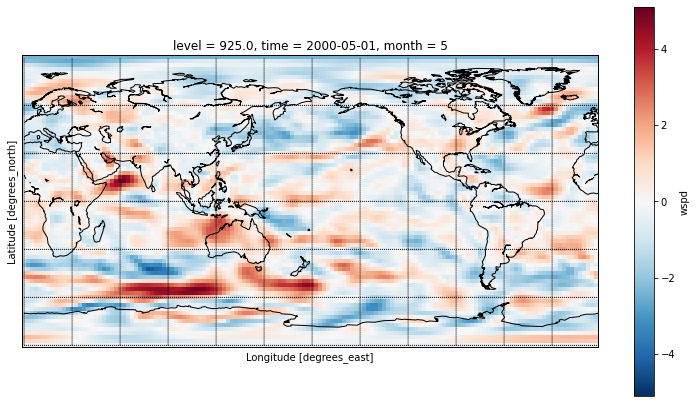

In [525]:
#basemap
fig = plt.figure(figsize=(10, 6))
fig.subplots_adjust(left=0., right=1., bottom=0., top=0.9)
m = Basemap(projection='cyl', llcrnrlat=-90, urcrnrlat=90,\
            llcrnrlon=0, urcrnrlon=360, resolution='c', lon_0=0)
m.drawcoastlines()
m.drawmapboundary()
# draw lat/lon grid lines every 30 degrees.
m.drawmeridians(np.arange(0,360,30))
m.drawparallels(np.arange(-90,90,30))
wspd_anom[0].plot()
#plt.title('monthly mean wind speed anomaly', 
         #fontsize = 10)


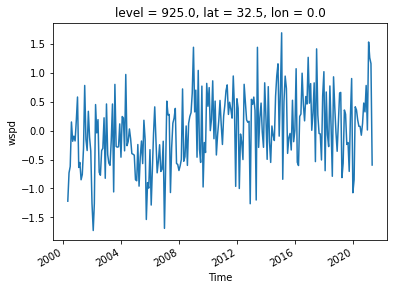

In [526]:
wspd_ref = wspd_anom.sel(lon=0, lat=32.7, method='nearest')
wspd_ref.plot()

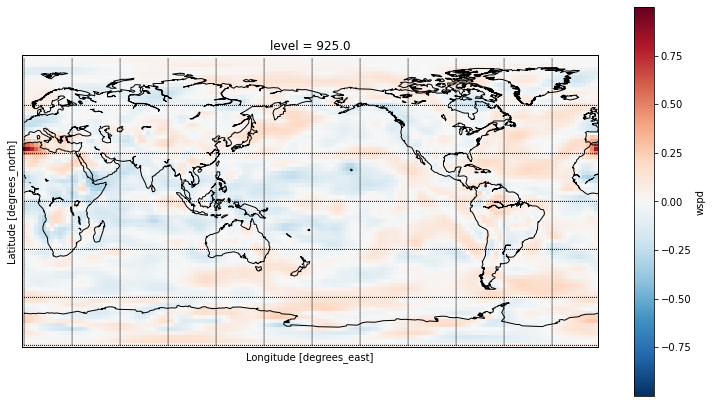

In [527]:
wspd_cor = corrrelation(wspd_anom, wspd_ref, dims='time')
#wspd_cor= correlation(wspd_anom, ntr_, dims='time')
#basemap
fig = plt.figure(figsize=(10, 6))
fig.subplots_adjust(left=0., right=1., bottom=0., top=0.9)
m = Basemap(projection='cyl', llcrnrlat=-90, urcrnrlat=90,\
            llcrnrlon=0, urcrnrlon=360, resolution='c', lon_0=0)
m.drawcoastlines()
m.drawmapboundary()
# draw lat/lon grid lines every 30 degrees.
m.drawmeridians(np.arange(0,360,30))
m.drawparallels(np.arange(-90,90,30))

pc = wspd_cor.plot()
#shows correlation of global average windspeed anomaly and windspeed at one point 

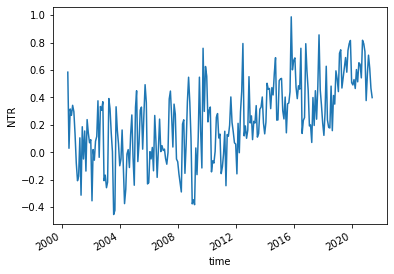

In [528]:
ntr.plot()

In [529]:
xr.corr(wspd, ntr, dim = 'time')

<xarray.DataArray (lat: 73, lon: 144)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    level    float32 925.0
  * lat      (lat) float32 90.0 87.5 85.0 82.5 80.0 ... -82.5 -85.0 -87.5 -90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5

In [530]:
da = ntr.expand_dims({'lat':73})
da
Da=da.expand_dims({'lon':144})


In [531]:
xr.corr(wspd, Da, dim = 'time')
cor = corrrelation(wspd, Da, dims='time')
cor

<xarray.DataArray (lat: 73, lon: 144)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * lat      (lat) float64 90.0 87.5 85.0 82.5 80.0 ... -82.5 -85.0 -87.5 -90.0
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
    level    float32 925.0

In [532]:
#wspd
#merged = xr.align(Da, wspd)
#merged